<a href="https://colab.research.google.com/github/nlemoff/Discovery-of-Undocumented-Oil-and-Gas-Wells/blob/main/GGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import plotly.express as px
data_path = 'B1320run125.csv'

data = pd.read_csv(data_path, skiprows=[1])
data['FY'] = pd.to_numeric(data['FY'], errors='coerce')
data['FX'] = pd.to_numeric(data['FX'], errors='coerce')
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['SR'] = pd.to_numeric(data['SR'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')


#data = data[{'FX','FY','SA','SR','FZ','V'}]
data.columns

Index(['ET', 'V', 'N', 'SA', 'IA', 'RL', 'RE', 'P', 'FX', 'FY', 'FZ', 'MX',
       'MZ', 'NFX', 'NFY', 'RST', 'TSTI', 'TSTC', 'TSTO', 'AMBTMP', 'SR',
       'SL'],
      dtype='object')

In [58]:
import pandas as pd
import plotly.graph_objects as go

# Load the cleaned data
# Define the path to the CSV file
data_path = 'B1320run125.csv'

# Load the data, skipping the first row which contains units
data = pd.read_csv(data_path, skiprows=[1])

# Convert relevant columns to numeric, coercing errors to NaN
data['FY'] = pd.to_numeric(data['FY'], errors='coerce')
data['FX'] = pd.to_numeric(data['FX'], errors='coerce')
data['SA'] = pd.to_numeric(data['SA'], errors='coerce')
data['FZ'] = pd.to_numeric(data['FZ'], errors='coerce')
data['V'] = pd.to_numeric(data['V'], errors='coerce')

# Define mass
mass = 241  # kg

# Calculate accelerations
data['AY'] = data['FY'] / mass
data['AX'] = data['FX'] / mass

# Define a specific vertical load bin range
vertical_load_bin = (-800, -400)

# Initialize a 3D figure
fig = go.Figure()

# Plot for each unique velocity
for v in sorted(data['V'].unique()):
    # Filter data for the specific velocity and vertical load bin
    data_velocity = data[(data['FZ'] >= vertical_load_bin[0]) & (data['FZ'] < vertical_load_bin[1]) & (data['V'] == v)]

    # Drop rows with NaN values
    data_velocity_cleaned = data_velocity.dropna(subset=['AY', 'AX', 'SA'])

    # Add traces to the 3D plot
    fig.add_trace(
        go.Scatter3d(
            x=data_velocity_cleaned['AY'],
            y=data_velocity_cleaned['AX'],
            z=np.full(len(data_velocity_cleaned), v),
            mode='markers',
            marker=dict(
                size=3,
                opacity=0.8
            ),
            name=f'Velocity {v} m/s'
        )
    )

# Update the layout
fig.update_layout(
    title='3D Scatter Plot of Tire Data',
    scene=dict(
        xaxis_title='Lateral Acceleration (AY) [m/s²]',
        yaxis_title='Longitudinal Acceleration (AX) [m/s²]',
        zaxis_title='Velocity (V) [m/s]'
    ),
    scene_aspectmode='cube'
)

# Show the plot
fig.show()


In [9]:
fig.show()

(FY vs SA) Load Range -800 to -400
Optimal Parameters:
B: 0.3058037825820342
C: 0.046330354910867996
D: 36579.333951362816
E: 1.1485337034038394
F: 0.0003257978601443132
R² Accuracy: 0.965

(FX vs SR) Load Range -800 to -400
Optimal Parameters:
B: -10.489908760609138
C: 1.5770157220660874
D: 1669.0621621010648
E: 0.43377626874735864
F: -0.18416387600099735
R² Accuracy: 0.973

In [53]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def get_max_grip_for_load_bin_lat(load_bin, data):
    # Define the simplified Pacejka model function
    def pacejka_model(alpha, B, C, D, E, F):
        return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

    lower_bound, upper_bound = load_bin

    # Filter the data based on the provided load bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    # Check if there's enough data in this bin
    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    # Prepare the data for curve fitting
    x_data = load_data['SA']
    y_data = load_data['FY']

    # Apply curve fitting to find the optimal coefficients for the load bin
    initial_guess = [0.5, 1.2, max(load_data['FY']), 1, 0]
    optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)

    # Generate model predictions over the range of slip angles for visualization
    x_model = np.linspace(x_data.min(), x_data.max(), 500)
    y_model = pacejka_model(x_model, *optimal_parameters)

    # Extract and return the maximum grip value (FY) from the model predictions
    max_grip = max(y_model)

    return max_grip


#get_max_grip_for_load_bin_lat([-800,-400], data)


lower_bound, upper_bound = [-800,-400]
load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]
load_data[load_data['V'] == 40.04]

# fit a pacejka curve for each velocity on a given load range
# the max of the pacejak curve is going to represent the max grip
# use max grip to calculate max acceleartion at max grip


,ET,V,N,SA,IA,RL,RE,P,FX,FY,...,MZ,NFX,NFY,RST,TSTI,TSTC,TSTO,AMBTMP,SR,SL
2057,95.180,40.04,457.33,-0.008,0.024,25.841,23.229,82.95,1867.97,-0.30,...,50.87,-2.98,0.00,35.83,63.24,66.11,76.87,79.69,0.112,0.127
2218,107.120,40.04,407.11,0.017,2.015,25.778,26.095,82.95,30.77,60.68,...,45.35,-0.05,-0.09,35.51,62.01,67.59,78.04,79.80,-0.012,0.000
2417,111.200,40.04,343.68,0.032,2.020,25.720,30.911,82.81,-1860.11,30.14,...,11.47,2.77,-0.04,36.20,64.93,73.05,88.17,79.75,-0.168,-0.155
2453,111.920,40.04,363.96,0.017,2.009,25.740,29.185,82.95,-1765.03,32.11,...,2.31,2.55,-0.05,36.36,64.19,71.74,87.00,79.73,-0.118,-0.105
2457,112.000,40.04,366.62,0.020,2.009,25.746,28.973,82.88,-1711.67,34.57,...,23.31,2.54,-0.05,36.32,64.14,71.51,86.82,79.73,-0.111,-0.098
2754,126.760,40.04,397.93,0.014,4.021,25.806,26.697,82.81,-983.51,97.44,...,43.54,1.48,-0.15,35.61,60.45,66.94,76.62,79.91,-0.033,-0.025
8020,319.320,40.04,410.16,-2.987,0.028,25.704,25.862,82.74,214.39,1298.91,...,-16.56,-0.32,-1.94,35.26,67.36,75.67,88.04,80.36,-0.006,0.010
8026,319.440,40.04,406.45,-2.984,0.024,25.701,26.099,82.88,29.80,1300.95,...,-8.65,-0.05,-1.99,35.30,67.07,75.45,87.76,80.38,-0.015,0.001
8027,319.460,40.04,406.09,-2.984,0.021,25.702,26.121,82.81,9.88,1316.34,...,-17.97,-0.01,-1.97,35.06,67.02,75.42,87.71,80.36,-0.016,0.000
8330,325.520,40.04,403.24,-2.990,0.027,25.687,26.306,82.88,-184.91,1316.59,...,-0.18,0.28,-1.99,36.79,67.23,74.52,86.53,80.27,-0.024,-0.004


In [57]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def interpolate_data(x_data, y_data, num_points=100):
    # Perform linear interpolation to generate additional data points
    interp_func = interp1d(x_data, y_data, kind='linear')
    x_interpolated = np.linspace(x_data.min(), x_data.max(), num_points)
    y_interpolated = interp_func(x_interpolated)
    return x_interpolated, y_interpolated

def get_max_grip_by_velocity_lat(data, load_bin):
    # Initialize a dictionary to store max grip for each velocity
    max_grip_by_velocity = {}

    # Filter the data based on the provided load bin
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    # Check if there's enough data in this bin
    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    # Group the filtered data by velocity
    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SA']
        y_data = group['FY']

        # Check if there's enough data for this velocity
        if len(x_data) < 3 or len(y_data) < 3:  # Arbitrarily chosen minimum data points requirement
            #print(f"Not enough data points for velocity {velocity}.")
            continue

        # Interpolate data to generate additional points
        x_interpolated, y_interpolated = interpolate_data(x_data, y_data)

        # Apply curve fitting to find the optimal coefficients for this velocity group
        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_interpolated, y_interpolated, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            #print(f"Curve fitting failed for velocity {velocity} with error: {e}")
            continue

    return max_grip_by_velocity

# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results_lat = get_max_grip_by_velocity_lat(data, load_bin)
print(max_grip_results_lat)


{39.6: 1211.4480781798077, 39.64: 1174.3402931281018, 39.68: 1979.652574336688, 39.7: 1297.148430249127, 39.74: 1438.4273263674804, 39.75: 1404.9942250185227, 39.8: 947.9534753814957, 39.82: 1494.795059232352, 39.84: 1264.2013763950406, 39.85: 1348.1120730130324, 39.86: 1254.5070139537147, 39.87: 1094.869962980984, 39.91: 956.4666974015804, 39.92: 1024.8339047887678, 39.94: 1221.753917930314, 39.98: 696.4198506848475, 39.99: 1115.493320042277, 40.07: 694.1787742707818, 40.08: 1341.3939751638948, 40.09: 769.310225617991, 40.1: 818.8626896033213, 40.11: 1157.9609770269003, 40.12: 1210.5232119317984, 40.14: 913.4924779901557, 40.18: 573.2498734740701, 40.19: 936.6461395114869, 40.2: 928.3273760667172, 40.22: 1288.3163386169065, 40.23: 1251.5083109547252, 40.24: 918.048904095499, 40.26: 1059.195575180597, 40.27: 1397.61948563333, 40.28: 964.5036379323292, 40.29: 728.2076781675187, 40.31: 799.0585426124901, 40.34: 872.1873561625056, 40.35: 846.0237651765091, 40.36: 653.7299174695489, 40.37:

In [56]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def interpolate_data(x_data, y_data, num_points=100):
    # Perform linear interpolation to generate additional data points
    interp_func = interp1d(x_data, y_data, kind='linear')
    x_interpolated = np.linspace(x_data.min(), x_data.max(), num_points)
    y_interpolated = interp_func(x_interpolated)
    return x_interpolated, y_interpolated

def get_max_grip_by_velocity_long(data, load_bin):
    # Initialize a dictionary to store max grip for each velocity
    max_grip_by_velocity = {}

    # Filter the data based on the provided load bin
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    # Check if there's enough data in this bin
    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    # Group the filtered data by velocity
    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SR']
        y_data = group['FX']

        # Check if there's enough data for this velocity
        if len(x_data) < 3 or len(y_data) < 3:  # Arbitrarily chosen minimum data points requirement
            #print(f"Not enough data points for velocity {velocity}.")
            continue

        # Interpolate data to generate additional points
        x_interpolated, y_interpolated = interpolate_data(x_data, y_data)

        # Apply curve fitting to find the optimal coefficients for this velocity group
        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_interpolated, y_interpolated, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            #print(f"Curve fitting failed for velocity {velocity} with error: {e}")
            continue
    return max_grip_by_velocity

# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results_long = get_max_grip_by_velocity_long(data, load_bin)
print(max_grip_results_long)


{39.6: -564.7770248622913, 39.61: 782.7010517350147, 39.67: -280.4647430895684, 39.68: 1081.6493552793013, 39.7: 1164.7089982733423, 39.71: 1383.3811599168203, 39.72: 1504.9026816217604, 39.73: 1298.5238761750873, 39.75: 1390.2311965522022, 39.77: 1762.144388161587, 39.78: 1655.4742320281634, 39.79: 1739.7025016192529, 39.8: 1155.131712849534, 39.81: 1969.7139215411273, 39.83: 1601.7845206600857, 39.84: 1799.906406728811, 39.85: 1340.7972083992272, 39.86: 1862.423485587759, 39.87: 1551.8037237668748, 39.88: 1806.9871305213758, 39.9: 1700.4704347852785, 39.95: 1877.891506050755, 39.97: 1452.515686455103, 39.98: 1772.007955661694, 39.99: 1414.725533845239, 40.0: 1530.720839306363, 40.02: 1640.1655361952758, 40.03: 1445.1372740044449, 40.04: 1504.5606967678634, 40.06: 1367.8245608176028, 40.08: 1482.329369641518, 40.09: 1593.5308808167174, 40.1: 1676.2780345891983, 40.11: 1675.2067305254934, 40.12: 1589.2271192604946, 40.13: 1447.7967297292566, 40.14: 1589.2430636667502, 40.15: 1717.10176

In [31]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def get_max_grip_for_load_bin_long(load_bin, data):
    # Define the simplified Pacejka model function
    def pacejka_model(alpha, B, C, D, E, F):
        return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

    lower_bound, upper_bound = load_bin

    # Filter the data based on the provided load bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    # Check if there's enough data in this bin
    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    # Prepare the data for curve fitting
    x_data = load_data['SR']
    y_data = load_data['FX']

    # Apply curve fitting to find the optimal coefficients for the load bin
    initial_guess = [0.75, 1.2, max(load_data['FX']), 1, 0]
    optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)

    # Generate model predictions over the range of slip angles for visualization
    x_model = np.linspace(x_data.min(), x_data.max(), 500)
    y_model = pacejka_model(x_model, *optimal_parameters)

    # Extract and return the maximum grip value (FY) from the model predictions
    max_grip = max(y_model)

    return max_grip


get_max_grip_for_load_bin_long([-800,-400], data)

1669.0592354007326

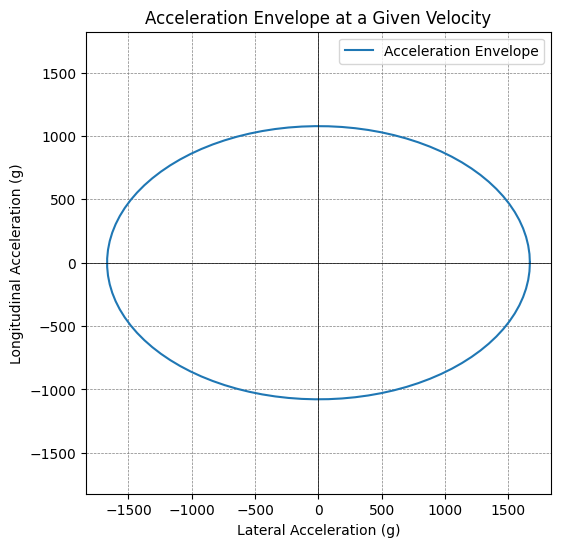

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Given values for max longitudinal and lateral acceleration
ax_max = 1669.0592354007326  # Placeholder value, replace with your calculation
ay_max = 1078.3652544032932  # Placeholder value, replace with your calculation

# Generate points for the ellipse
theta = np.linspace(0, 2 * np.pi, 100)
ax = ax_max * np.cos(theta)
ay = ay_max * np.sin(theta)

# Plotting
plt.figure(figsize=(6,6))
plt.plot(ax, ay, label='Acceleration Envelope')
plt.xlabel('Lateral Acceleration (g)')
plt.ylabel('Longitudinal Acceleration (g)')
plt.title('Acceleration Envelope at a Given Velocity')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.axis('equal')
plt.legend()
plt.show()
